# FSK-Modulation

## Grundlagen

Die Frequenzumtastung (Frequency Shift Keying, FSK) gehört wie die Frequenzmodulation im analogen Bereich zur Klasse der nichtlinearen Modulationsverfahren. Dies liegt daran, dass die Datensymbole $d[i]$ den Exponenten der komplexen Trägerschwingung beeinflussen. Mit dem Informationssignal 

\begin{equation}
    u(t)  = T_{\mathrm{s}} \cdot \sum_i d[i] \cdot g_{\mathrm{S}}(t - i T_{\mathrm{s}})
\end{equation}

bilden wir die komplexe Einhüllende einer FSK durch

\begin{equation}
    x_{\mathrm{FSK}}(t) 
    = e^{j 2 \pi \Delta F \cdot \int_0^t u(\tau) d\tau + j \varphi_0}
    = e^{j 2 \pi \Delta F T_{\mathrm{s}} \cdot \sum_i d[i] \cdot \int_0^t g_{\mathrm{S}}(\tau - i T_{\mathrm{s}})
        + j \varphi_0} \; .
\end{equation}

Dabei bezeichnen $\Delta F$ den Frequenzhub, $T_s$ die Symboldauer und $\varphi_0$ eine beliebige Startphase. Das analoge Informationssignal $u(t)$ wird bei der Frequenzmodulation im Exponenten der kompexen Trägerschwingung verwendet, um die Momentanfrequenz einzustellen. Damit bestimmen die Informationssymbole $d[i]$, in welche Phasenrichtung sich die komplexe Einhüllende dreht. Die Information steckt also in der Phasendifferenz aufeinanderfolgender Symbole, nicht in den absoluten Phasenwerten. Damit hängt die aktuelle Phase von allen bisherigen Datensymbolen ab, die FSK-Modulation hat also ein Gedächtnis. Aus der obigen Gleichung wird auch deutlich, dass die komplexe Einhüllende einen konstanten Betrag hat.

Eine wichtige Größe ist der Modulationsindex 

\begin{equation}
    \eta_{\mathrm{FSK}} = 2 \Delta F T_{\mathrm{s}} \; .
\end{equation}

Vergleichen wir ihn mit dem der analogen FM bei einem monofrequentem Informationssignal mit der Frequenz $f_1$, erhalten wir

\begin{equation}
    \eta_{\mathrm{FM}} = \frac{\Delta F}{f_1}
    \qquad \Rightarrow \qquad
    f_{\mathrm{N}} = \frac{1}{2 T_{\mathrm{S}}} = f_1 \; .
\end{equation}   

Bei der FSK übernimmt also die Nyquist-Frequenz $f_{\mathrm{N}}$ die Rolle der Frequenz $f_1$ bei der analogen FM. 

\begin{equation}
    x_{\mathrm{FSK}}(t) 
    = e^{j \pi \eta \cdot \sum_i d[i] \cdot \int_0^t g_{\mathrm{S}}(\tau - i T_{\mathrm{s}})
        + j \varphi_0}
\end{equation}

Wä

Im Folgenden gehen wir die einzelnen Verarbeitungsschritte beginnen mit den Informationsbit bis zum FSK-modulierten Signal durch.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ECCpath = '../ECCpython'
if (not ECCpath==None) and (not ECCpath in sys.path):
    sys.path.append(ECCpath)

from Modulation.modulation import Modulation

# ---------------------------------------------------------------------------------
# parameter definition 

# cardinality of modulation scheme
M = 2
# number of information bits to be generated
N_info_bits = 64

# number of bits per ASK symbol
m = int(np.round(np.log2(M)))
# number of symbols obtained from information bits
N_symbols = N_info_bits // m
time_symbol = np.arange(N_symbols)

# ---------------------------------------------------------------------------------
# ASK alphabet
ask = Modulation(m, coding_type='gray',modulation_type='ASK')


## Abbildung des Bitstrom auf analoges Signal $u(t)$

Zunächst wird der binäre Datenstrom mit den Informationsbit $u[k]$ auf die zeit- und wertediskreten Symbole $d[i]$ abgebildet. Diese sind bei einer FSK reellwertige ASK-Symbole. Das untere Bild zeigt einen exemplarischen Verlauf der $2$-ASK-Symbole $d[i]$.

Die Datensymbolfolge $d[i]$ muss nun in ein analoges, d.h. zeit- und wertekontinuierliches Signal $u(t)$ überführt werden. Dazu dient das Sendefilter, mit dessen Impulsantwort $g_{\mathrm{S}}(t)$ die Datenfolge zu falten ist. Für einfache Rechteckimpulse 

\begin{equation}
    g_{\mathrm{S}}(t) = 
    \begin{cases} 
        T_{\mathrm{s}}^{-1} & \text{für } 0 \leq t < T_{\mathrm{S}} \\ 
        0 & \text{sonst} 
    \end{cases}
\end{equation}

erhalten wir den im unteren Bild dargestellten exemplarischen Verlauf.

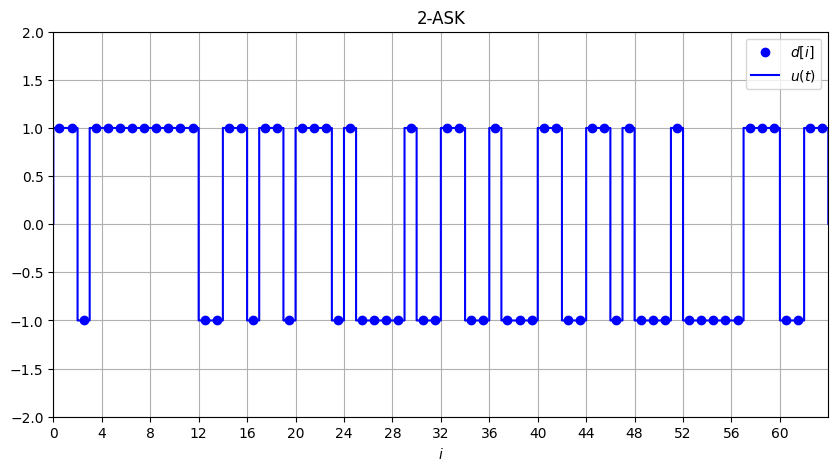

In [2]:
# ---------------------------------------------------------------------------------
# ASK modulation
# generate information bits u[k]
u = np.random.randint(0,2,N_info_bits)

# map information bits onto ASK 
d_ask = ask.modulate(u)
    
# ---------------------------------------------------------------------------------
# discrete-time convolution of data symbols with rectangular impulse response

# oversampling factor
w = 128
# length of filter impulse response in samples
L_ImpulseResponseSymbols = 8
# length of filter impulse response in samples
L_ImpulseResponseSamples = L_ImpulseResponseSymbols*w

# time axis
time = np.arange(-L_ImpulseResponseSymbols/2,L_ImpulseResponseSymbols/2,1.0/w)
dt = time[1]-time[0]

# oversampling data symbols by inserting w zeros 
d = np.append(np.reshape(d_ask,(N_symbols,1)),np.zeros((N_symbols,w-1)),axis=1)
d = np.reshape(d,(N_symbols*w,1))

# rectangular impulse for full-response system
N_rect = w
g_rect = np.zeros_like(time,dtype=float)
g_rect[np.where(time>0.0)] = 1.0
g_rect[np.where(time>N_rect/w)] = 0.0
# normalization such that integral delivers 1.0
g_rect /= (np.sum(g_rect) * dt)

u_rect = np.convolve(d.flatten(),g_rect)
timeConv = (np.arange(N_symbols*w+g_rect.shape[0]-1)-g_rect.shape[0]/2) / w

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.plot(time_symbol+0.5, d_ask, marker='o',color='blue',linestyle='none', label='$d[i]$')
ax1.step(timeConv,u_rect, 'b-', label='$u(t)$')
plt.xlabel('$i$')
plt.xticks(np.arange(0,N_symbols,4))
plt.title('%g-ASK' %(M))
plt.grid(True)
plt.axis([0, N_symbols, -M, M])
plt.legend()

## Phasenverlauf der komplexen Einhüllenden

Die Integration eines Rechteckimpulses ergibt eine Rampe.

\begin{equation}
    \int_0^t g_{\mathrm{S}}(\tau-lT_{\mathrm{s}}) \ d\tau
    = \begin{cases}
        0 & \text{für } t < l T_{\mathrm{s}} \\
        \frac{t}{T_{\mathrm{s}}} - l & \text{für } l T_{\mathrm{s}} \leq t < (l+1)T_{\mathrm{s}} \\
        1 & \text{für } t > T_{\mathrm{s}}
      \end{cases} 
\end{equation}

Damit kann die komplexe Einhüllende für das $l$-te Intervall in die Form

\begin{align}
    x_{\mathrm{FSK}}(t) 
    &= \exp \left[ j \pi \eta \cdot 
        \left( \sum_{i=0}^{l-1} d[i] + d[l] \left(\frac{t}{T_{\mathrm{s}}} - l \right) 
        + \varphi_0 \right) \right] \\
    &= \exp \left[ j \varphi(lT_{\mathrm{s}}) + j \pi \eta 
                   \cdot d[l] \left(\frac{t}{T_{\mathrm{s}}} - l \right) \right]
    \qquad \text{für} \qquad
    l T_{\mathrm{s}} \leq t < (l+1)T_{\mathrm{s}}
\end{align}

mit der Startphase $\varphi(lT_{\mathrm{s}}) = \pi \eta \cdot \sum_{i=0}^{l-1} d[i] + \varphi_0$ gebracht werden. Da jedes neue Intervall mit der Endphase des vorangegangenen Intervalls beginnt, hat die FSK mit rechteckförmigen Impulsen einen kontinuierlichen Phasenverlauf, wir sprechen daher von einer Continuous-Phase FSK (CPFSK). Der Phasenverlauf weit bei rechteckförmiger Impulsformung allerdings Knicke auf, er ist also nicht stetig differenzierbar.

Für eine 2-ASK mit $d[i] \in \{ -1, +1\}$ beträgt die maximale Phasendrehung während einer Symboldauer $T_{\mathrm{s}}$ genau 

\begin{equation}
    \left| \varphi( l T_{\mathrm{s}}) - \varphi( (l-1) T_{\mathrm{s}}) \right| = \pi \eta \; . 
\end{equation}


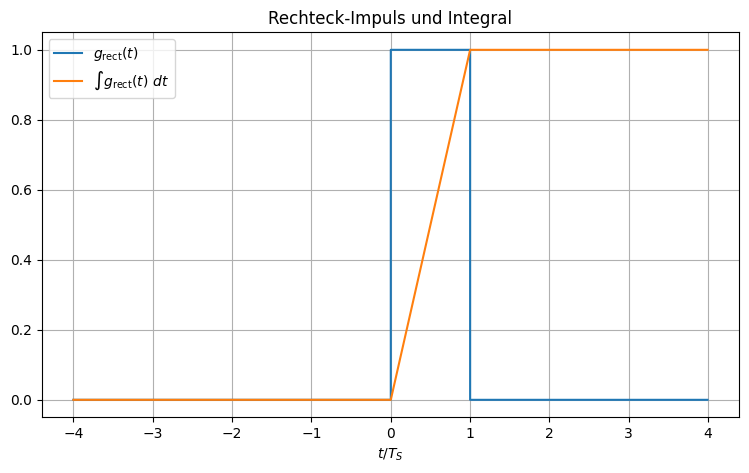

In [18]:
# integration 
int_g_rect = np.cumsum(g_rect) * dt

fig2 = plt.figure(figsize=(9,5))
ax2 = fig2.add_subplot(111)
ax2.step(time,g_rect, '-', label='$g_{\mathrm{rect}}(t)$')
ax2.plot(time,int_g_rect, '-', label='$\int g_{\mathrm{rect}}(t) \ dt$')
plt.xlabel('$t/T_S$')
#plt.ylabel('$g_S(t)$')
plt.title('Rechteck-Impuls und Integral')
plt.grid(True)
plt.legend()


Das obere Bild illustriert den Verlauf des Informationssignals $u(t)$ für eine 2-FSK, es wird also eine 2-ASK verwendet um die Momentanfrequenz einzustellen. Die Impulse sind so normiert, dass ihre Integrale den Wert Eins ergeben. 

Damit ergibt sich im unteren Bild der zugehörige Phasenverlauf nach der Integration. Man erkennt, dass es keine Phasensprünge, sehr wohl aber Knicke im Phasenverlauf gibt. Die Startphase jedes Intervalls ist immer die Endphase des vorangegangenen Intervalls, wir erhalten mit Rechteckimpulsen also eine CPFSK. 

(-7.853981633974483, 1.5707963267948966)

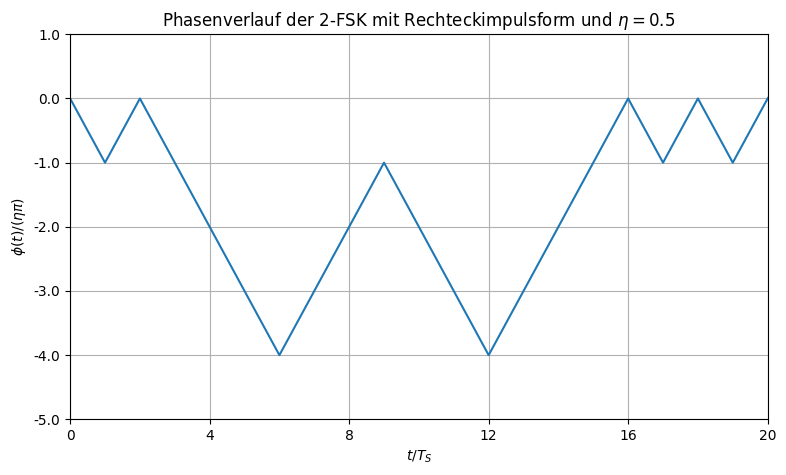

In [19]:
# modulation index
eta = np.array([0.25, 0.5, 2.0/3.0, 1.0])

phi_rect = np.outer(np.cumsum(u_rect), eta * np.pi * dt)

xmaxPlot = 20
ymin = int(np.floor(np.amin(phi_rect[:(xmaxPlot+4)*w,1]/(eta[1]*np.pi)))-1)
ymax = int(np.ceil(np.amax(phi_rect[:(xmaxPlot+4)*w,1]/(eta[1]*np.pi)))+1)

fig3 = plt.figure(figsize=(9,5))
ax3 = fig3.add_subplot(111)
ax3.plot(timeConv,phi_rect[:,1], '-', label='eta=%1.1f' %(eta[1]))
plt.xlabel('$t/T_S$')
plt.ylabel('$\phi(t) / (\eta \pi)$')
plt.title('Phasenverlauf der %d-FSK mit Rechteckimpulsform und $\eta=$%1.1f' %(M,eta[1]))
plt.grid(True)
plt.xticks(np.arange(0,xmaxPlot+1,4))
plt.yticks(np.linspace(ymin*eta[1]*np.pi,ymax*eta[1]*np.pi,ymax-ymin+1))
ax3.set_yticklabels(np.linspace(ymin,ymax,ymax-ymin+1))
plt.xlim(0,xmaxPlot)
plt.ylim(ymin*eta[1]*np.pi,ymax*eta[1]*np.pi)


Eine genauere Betrachtung der obigen Phasenverläufe offenbart außerdem, dass zu den idealen Abtastzeitpunkten $i T_{\mathrm{s}}$ nur ganzzahlige Vielfache von $\pi \eta$ auftreten. Wir sehen im Bild unten die Ortskurven für verschieden Modulationsindizes $\eta$. Wir erkennen, dass zu den idealen Abtastzeitpunkten nur diskrete Symbole vorkommen. Ihre Anzahl hängt von $\eta$ ab. Eine besondere Rolle hat der Wert $\eta=\frac{1}{2}$. Er repräsentiert den kleinsten Modulationsindex, für den die beiden Elementarschwingungen $e^{j \pi \eta t}$ und $e^{-j \pi \eta t}$ orthogonal zueinander sind. Daher wird die 2-FSK für $\eta = \frac{1}{2}$ auch Minimum Shift Keying (MSK) genannt. Sie findet unter anderem im Mobilfunksystem der 2. Generation (GSM) Verwendung. 

<function matplotlib.pyplot.show(close=None, block=None)>

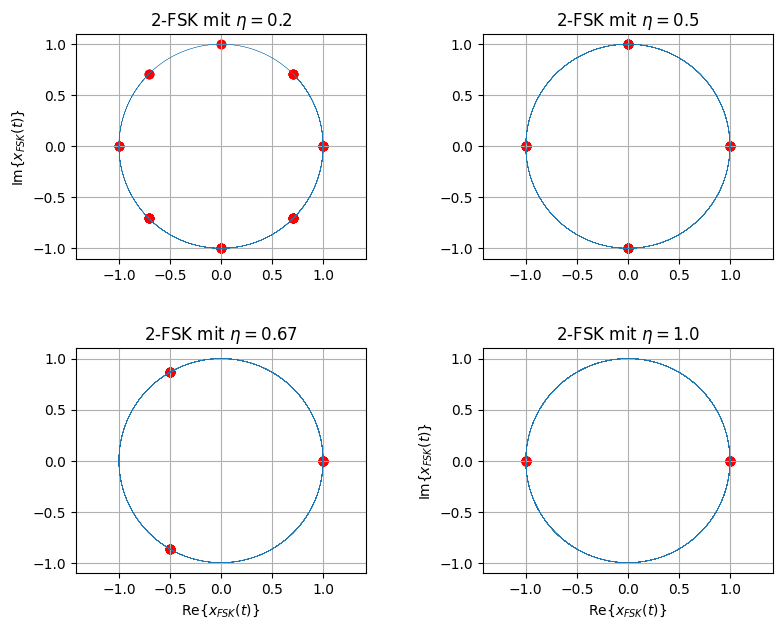

In [20]:
x_rect = np.exp(1j*phi_rect)

fig4 = plt.figure(figsize=(9,7))
# set the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax4 = fig4.add_subplot(221)
ptrRect = np.arange(0,x_rect.shape[0],w,dtype=int)
ax4.plot(np.real(x_rect[:,0]),np.imag(x_rect[:,0]),'-',linewidth=0.25)
ax4.scatter(np.real(x_rect[ptrRect,0]), np.imag(x_rect[ptrRect,0]), c="r")
plt.xlim(-1,1)

ax4.axis('equal')
#plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.ylabel('Im$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit $\eta=$%1.1f' %(M,eta[0]))
plt.grid(True)
#plt.xticks(np.arange(0,33,4))
#plt.yticks(ask)

ax4 = fig4.add_subplot(222)
ax4.plot(np.real(x_rect[:,1]),np.imag(x_rect[:,1]),'-',linewidth=0.25)
ax4.scatter(np.real(x_rect[ptrRect,1]),np.imag(x_rect[ptrRect,1]), c="r")
plt.xlim(-1,1)

ax4.axis('equal')
#plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit $\eta=$%1.1f' %(M,eta[1]))
plt.grid(True)

ax4 = fig4.add_subplot(223)
ax4.plot(np.real(x_rect[:,2]),np.imag(x_rect[:,2]),'-',linewidth=0.25)
ax4.scatter(np.real(x_rect[ptrRect,2]),np.imag(x_rect[ptrRect,2]), c="r")
plt.xlim(-1,1)

ax4.axis('equal')
plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit $\eta=$%1.2f' %(M,eta[2]))
plt.grid(True)

ax4 = fig4.add_subplot(224)
ax4.plot(np.real(x_rect[:,3]),np.imag(x_rect[:,3]),'-',linewidth=0.25)
ax4.scatter(np.real(x_rect[ptrRect,3]),np.imag(x_rect[ptrRect,3]), c="r")
plt.xlim(-1,1)

ax4.axis('equal')
plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.ylabel('Im$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit $\eta=$%1.1f' %(M,eta[3]))
plt.grid(True)

plt.show

## Alternative Impulsformen

Man kann die Rechteckimpulse auch länger als eine Symboldauer $T_s$ machen. Dann spricht man von Partial-Response-Systemen, da nur ein Teil der Impulsantwort in eine Symboldauer fällt. Demgegenüber spricht man von Full-Response-Systemen, wenns sich  der Impuls auf eine Symboldauer beschränkt. Der Vorteil von Partial-Response-Signalen sind kleinere Knicke im Phasenverlauf, was zu einer reduzierten Bandbreite führt. Dafür steigt das Gedächtnis und man erhält Intersymbolinterferenzen, die am Empfänger entzerrt werden müssen. 

Außerdem eignen sich neben Rechteckimpulsen auch Kosinus-Rolloff-Filter oder Gaußtiefpässe. Während erstere die 1. Nyquistbedingung erfüllen können, ist dies bei Gaußimpulsen nicht der Fall, bei ihnen kommt es also immer zu ISI.

Das untere Bild illustriert den Verlauf des Informationssignals $u(t)$ für eine 2-FSK und verschiedene Impulsformen. Die Impulse werden später so normiert, dass ihre Integrale den Wert Eins ergeben. Während Rechteck- und Kosinus-Rolloff-Impulse die 1. Nyquist-Bedingung erfüllen und zu den idealen Abtastzeitpunkten die Datensymbole direkt abgelesen werden können, gilt dies für den Gaußimpuls nicht. Hier treten Intersymbolinterferenzen auf, was anhand der Marker zu erkennen ist. 


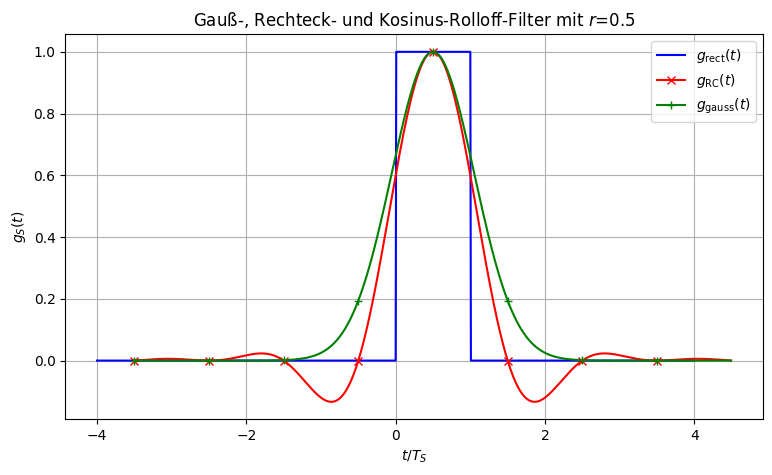

In [22]:
# roll-off factor of raised-cosine filter
r = 0.5
# span of impulse response in number of samples
N_rc = L_ImpulseResponseSymbols * w
timeRC,g_rc = ask.rcosfilter(N_rc,r,1.0,w)


# Gaussian impulse with 3dB bandwidth 
f3dB = w * 0.01
g_gauss = np.exp(-(time * f3dB)**2)
#g_gauss /= np.sum(g_gauss)

fig5 = plt.figure(figsize=(9,5))
ax5 = fig5.add_subplot(111)
ax5.plot(time,g_rect, 'b-', label='$g_{\mathrm{rect}}(t)$')
ax5.plot(timeRC+0.5,g_rc, 'r-x', markevery=(w), label='$g_{\mathrm{RC}}(t)$')
ax5.plot(time+0.5,g_gauss, 'g-+', markevery=(w), label='$g_{\mathrm{gauss}}(t)$')
plt.xlabel('$t/T_S$')
plt.ylabel('$g_S(t)$')
plt.title('Gauß-, Rechteck- und Kosinus-Rolloff-Filter mit $r$=%1.1f' %(r))
plt.grid(True)
plt.legend()


Das untere Bild illustriert $u(t)$ für drei Beispiele, einen Reckeckimpuls, einen Gaußimpuls und einen Kosinus-Rolloff-Impuls. Gauß- und Kosinuns-Rolloff-Impulse sind nicht auf eine Symboldauer $T_{\mathrm{s}}$ begrenzt, stellen somit Partial-Response-Systeme dar. Die Impulse sind werden später so normiert, dass ihre Integrale den Wert Eins ergeben.

(0.0, 20.0)

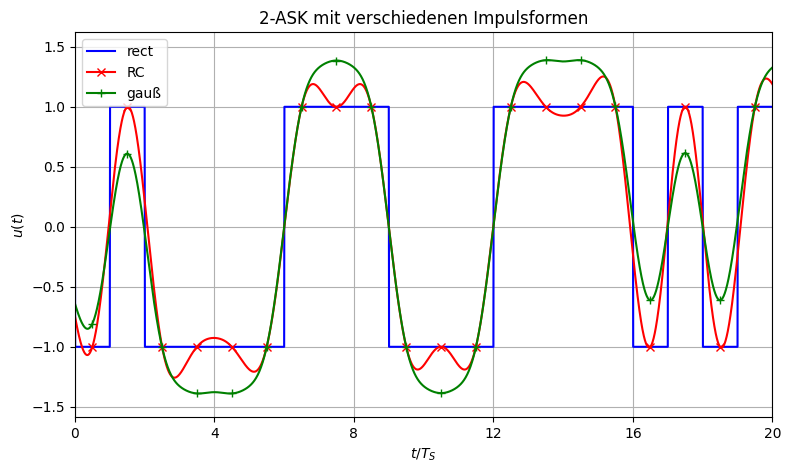

In [23]:
# discrete-time convolution of data symbols with impulse responses 
u_rc = np.convolve(d.flatten(),g_rc)
u_gauss = np.convolve(d.flatten(),g_gauss)


fig6 = plt.figure(figsize=(9,5))
ax6 = fig6.add_subplot(111)
ax6.plot(timeConv,u_rect, 'b-', label='rect')
ax6.plot(timeConv+0.5,u_rc, 'r-x', markevery=w, label='RC')
ax6.plot(timeConv+0.5,u_gauss, 'g-+',markevery=w,label='gauß')
plt.xlabel('$t/T_S$')
plt.ylabel('$u(t)$')
plt.title('%d-ASK mit verschiedenen Impulsformen' %(M))
plt.grid(True)
plt.legend()
plt.xticks(np.arange(0,33,4))
plt.xlim(0,20)
#plt.ylim(-0.2,0.2)


(-7.853981633974483, 3.141592653589793)

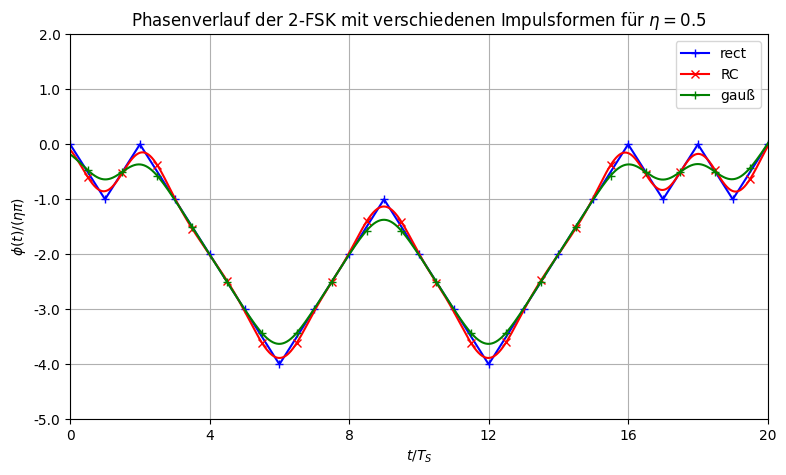

In [24]:
# integration over time
ptr_eta = 1
phi_rc = np.cumsum(u_rc) * eta[ptr_eta] * np.pi * dt
phi_gauss = np.cumsum(u_gauss) * eta[ptr_eta] * np.pi / np.sum(g_gauss)

xmaxPlot = 20
ymin = int(np.floor(np.amin(phi_rc[:(xmaxPlot+4)*w]/(eta[ptr_eta]*np.pi)))-1)
ymax = int(np.ceil(np.amax(phi_rc[:(xmaxPlot+4)*w]/(eta[ptr_eta]*np.pi)))+1)

fig7 = plt.figure(figsize=(9,5))
ax7 = fig7.add_subplot(111)
ax7.plot(timeConv,phi_rect[:,ptr_eta], 'b-+', markevery=w, label='rect')
ax7.plot(timeConv+0.5,phi_rc, 'r-x', markevery=w, label='RC')
ax7.plot(timeConv+0.5,phi_gauss, 'g-+',markevery=w,label='gauß')
plt.xlabel('$t/T_S$')
plt.ylabel('$\phi(t) / (\eta \pi)$')
plt.title('Phasenverlauf der %d-FSK mit verschiedenen Impulsformen für $\eta=$%1.1f' %(M,eta[ptr_eta]))
plt.grid(True)
plt.legend()
plt.xticks(np.arange(0,xmaxPlot+1,4))
plt.yticks(np.linspace(ymin*eta[ptr_eta]*np.pi,ymax*eta[ptr_eta]*np.pi,ymax-ymin+1))
ax7.set_yticklabels(np.linspace(ymin,ymax,ymax-ymin+1))
plt.xlim(0,xmaxPlot)
plt.ylim(ymin*eta[ptr_eta]*np.pi,ymax*eta[ptr_eta]*np.pi)


Im oberen Bild sind die exemplarischen PhasenVerläufe der komplexen Einhüllenden $x_{FSK}(t)$ dargestellt, wobei die Marker die idealen Abtastzeitpunkte markieren. Man erkennt, dass beim Rechteckimpuls an den idealen Abtastzeitpunkten exakt die gewünschten Phasenwerte (ganzzahlige Vielfache von $\pm \eta \pi$ auftreten. Für das Beispiel $\eta=0.5$ sind dies also ganzzahlige Vielfache der Phase $\pi/2$. Dies liegt an der auf $T_s$ begrenzten Symboldauer und der Normierung des Integrals auf den Wert Eins. 

Für Kosinus-Rolloff- und Gaußimpulse sind diese Werte allerdings nicht zu beobachten. Vielmehr treten Häufungen um diese Werte herum auf. Dies liegt an den Intersymbolinterferenzen, die für diese Partial-Response-Impulsformen auftreten.

Die Information ist nicht in den absoluten Phasenwerten codiert, sondern in der Differenz aufeinanderfolgender Phasenwerte. Nach der Phasendetektion ist also eine differentielle Decodierung durchzuführen.

<function matplotlib.pyplot.show(close=None, block=None)>

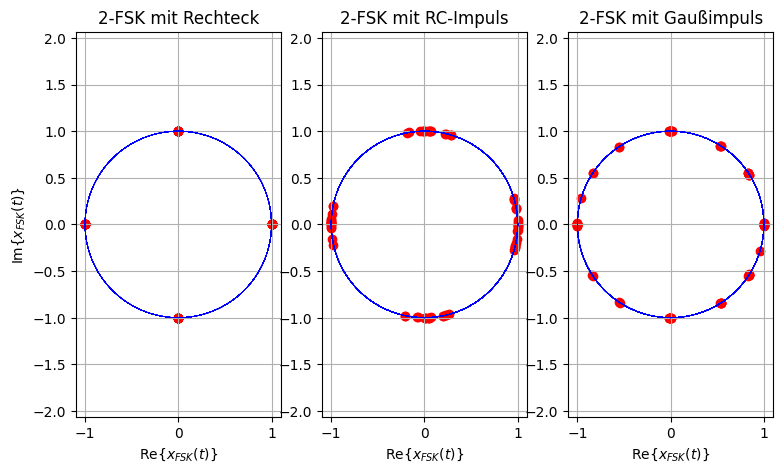

In [28]:
x_rc = np.exp(1j*phi_rc)
x_rect = np.exp(1j*phi_rect)
x_gauss = np.exp(1j*phi_gauss)

fig8 = plt.figure(figsize=(9,5))

ax8a = fig8.add_subplot(131)
ptrRect = np.arange(0,x_rc.shape[0],w,dtype=int)
ax8a.plot(np.real(x_rect[:,ptr_eta]),np.imag(x_rect[:,ptr_eta]),'b-', linewidth=0.5)
ax8a.scatter(np.real(x_rect[ptrRect,ptr_eta]), np.imag(x_rect[ptrRect,ptr_eta]), c="r")
plt.xlim(-1,1)

ax8a.axis('equal')
plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.ylabel('Im$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit Rechteck' %(M))
plt.grid(True)
#plt.xticks(np.arange(0,33,4))
#plt.yticks(ask)

ax8b = fig8.add_subplot(132)
ptrRC = np.arange(w/2,len(x_rc),w,dtype=int)
ax8b.plot(np.real(x_rect),np.imag(x_rect),'b-', linewidth=0.5)
ax8b.scatter(np.real(x_rc[ptrRC]),np.imag(x_rc[ptrRC]), c="r")
plt.xlim(-1,1)

ax8b.axis('equal')
plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit RC-Impuls' %(M))
plt.grid(True)

ax8c = fig8.add_subplot(133)
ptrGauss = np.arange(w/2,len(x_rc),w,dtype=int)
ax8c.plot(np.real(x_rect),np.imag(x_rect),'b-', linewidth=0.5)
ax8c.scatter(np.real(x_gauss[ptrGauss]),np.imag(x_gauss[ptrGauss]), c="r")
plt.xlim(-1,1)

ax8c.axis('equal')
plt.xlabel('Re$\{ x_{FSK}(t)\}$')
plt.title('%d-FSK mit Gaußimpuls' %(M))
plt.grid(True)

plt.show

## Leistungsdichtespektrum 

Da das modulierte Signal ein stochastisches Signal ist, kann nicht einfach die Fourier-Transformierte zur Bestimmung des Spektrums berechnet werden. Vielmehr wird das Leistungdichtespektrum verwendet, das die mittlere Verteilung der Leistung über der Frequenz angibt. Es berechnet sich nach dem Theorem von Wiener und Khintchine aus der Fourier-Transformierten der Autokorrelationsfunktion. Die analytische Berechnung des Leistungsdichtespektrums für die allgmeine FSK gestaltet sich als sehr aufwändig und numerisch anspruchsvoll. Wir begnügen uns daher mit der numerischen Berechnung. 

Für eine akzeptable Auflösung im Frequenzbereich benötigen wir deutlich längere Sequenzen als bisher. Da die Berechnung der Autokorrelationsfunktion und ihrer Fourier-Transformierten dann sehr aufwändig wird, verwenden wir Methode nach Welch. Dabei wird der Datenstrom in Abschnitte einer definierten Länge unterteilt. 

Die erzielten Ergebnisse sind im Bild unten dargestellt. Es ist zu erkennen, dass die rechteckförmigen Impulse einen höheren Bandbreitebedarf haben als Kosinus-Rolloff- und Gauß-Tiefpässe. Je kleiner der Modulationsindex $\eta$, desto kleiner die Phasendrehung pro Symboldauer und je schneller fallen die Spektren ab. Den geringsten Bandbreitebedarf hat der Gaußtiefpass, er sorgt allerdings auch für die stärksten Intersymbolinterferenzen und benötigt aufwändige Entzerrungsmaßnahmen. Im  Vergleich zu den linearen Modulationsverfahren ist der Bandbreitebedarf der FSK größer, sie erlaubt aber eine einfache inkohärente Demodulation.

In [32]:
from scipy import signal

# number of FSK symbols
N = 1000

# averaging for power density spectrum
Npsd = 10

# extract tuples of m bits
u = np.random.randint(0,2,N*m)

# map information bits to ASK symbols
d = ask.modulate(u)
    
# upsampling and convolution with impulse responses of filters
dUp= np.append(np.reshape(d,(N,1)),np.zeros((N,w-1)),axis=1)
dUp = np.reshape(dUp,(N*w,1))
uRect = np.convolve(dUp.flatten(),g_rect)
xRect1 = np.exp(1j*np.pi*eta[ptr_eta]*uRect)
xRect2 = np.exp(1j*np.pi*eta[0]*uRect)

uRC = np.convolve(dUp.flatten(),g_rc)
xRC = np.exp(1j*np.pi*eta[ptr_eta]*uRC)

uGauss = np.convolve(dUp.flatten(),g_gauss)
xGauss = np.exp(1j*np.pi*eta[ptr_eta]*uGauss)

timeConv2 = (np.arange(N*w+N_rc-1)-N_rc/2) / w  


# estimation of power spectral density with Welch method
f, psdRect1 = signal.welch(xRect1, fs=w, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)
f, psdRect2 = signal.welch(xRect2, fs=w, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)
f, psdRC = signal.welch(xRC, fs=w, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)
f, psdGauss = signal.welch(xGauss, fs=w, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)

# rearrange positive and negative frequencies
f = np.fft.fftshift(f)
psdRect1 = np.fft.fftshift(psdRect1)
psdRect2 = np.fft.fftshift(psdRect2)
psdRC = np.fft.fftshift(psdRC) 
psdGauss = np.fft.fftshift(psdGauss)


(np.float64(-2.0), np.float64(2.0), np.float64(1e-06), np.float64(2.0))

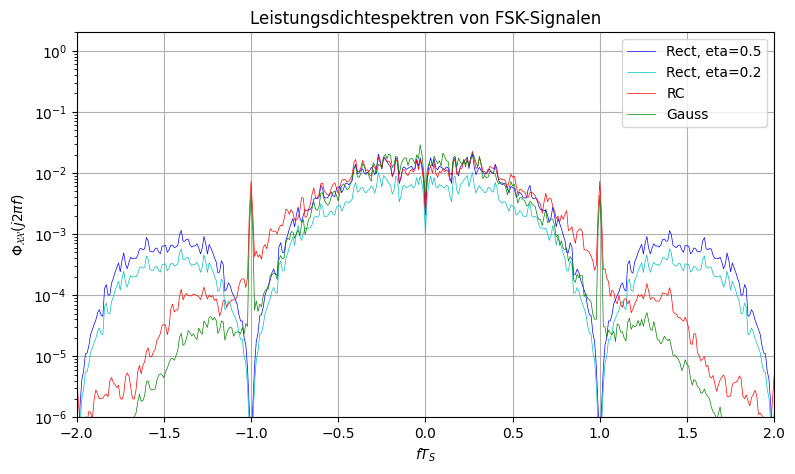

In [33]:
fig_psd = plt.figure(figsize=(9,5))
ax = fig_psd.add_subplot(111)
ax.semilogy(f, psdRect1,'b-',label='Rect, eta=%1.1f'%(eta[ptr_eta]), linewidth=0.5)
ax.semilogy(f, psdRect2,'c-',label='Rect, eta=%1.1f'%(eta[0]), linewidth=0.5)
ax.semilogy(f, psdRC,'r-',label='RC', linewidth=0.5)
ax.semilogy(f, psdGauss,'g-',label='Gauss', linewidth=0.5)
plt.title('Leistungsdichtespektren von FSK-Signalen')
plt.xlabel('$f T_S$')
plt.ylabel('$\Phi_{\cal XX}(j 2 \pi f)$')
plt.legend()
plt.grid(True)
plt.axis([-2, 2, 1e-6, 2])